# 신용카드 사용자 연체 예측 최고성능 모델링

이 노트북은 **Private 4위** 솔루션의 핵심 전략인 **그룹별 통계 피처**와 **교차 검증 강화** 기법을 적용한 고성능 모델링 파일입니다.

## 핵심 개선 전략
1. **그룹별 통계량(Aggregated Features)**: 직업군/교육수준별 소득 평균 및 편차 피처 생성
2. **비율 피처(Ratio Features)**: 그룹 평균 소득 대비 개인 소득 비중 등 상대적 가치 산출
3. **빈도 인코딩(Frequency Encoding)**: 범주형 변수의 출현 빈도를 수치화
4. **강화된 교차 검증**: 10-Fold Stratified K-Fold 적용

## 1. 라이브러리 및 데이터 로드

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
import warnings

warnings.filterwarnings('ignore')
plt.rc('font', family='Malgun Gothic')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

## 2. 상세 탐색적 데이터 분석 (EDA)
그룹별 소득의 차이가 연체율에 미치는 영향을 분석합니다.

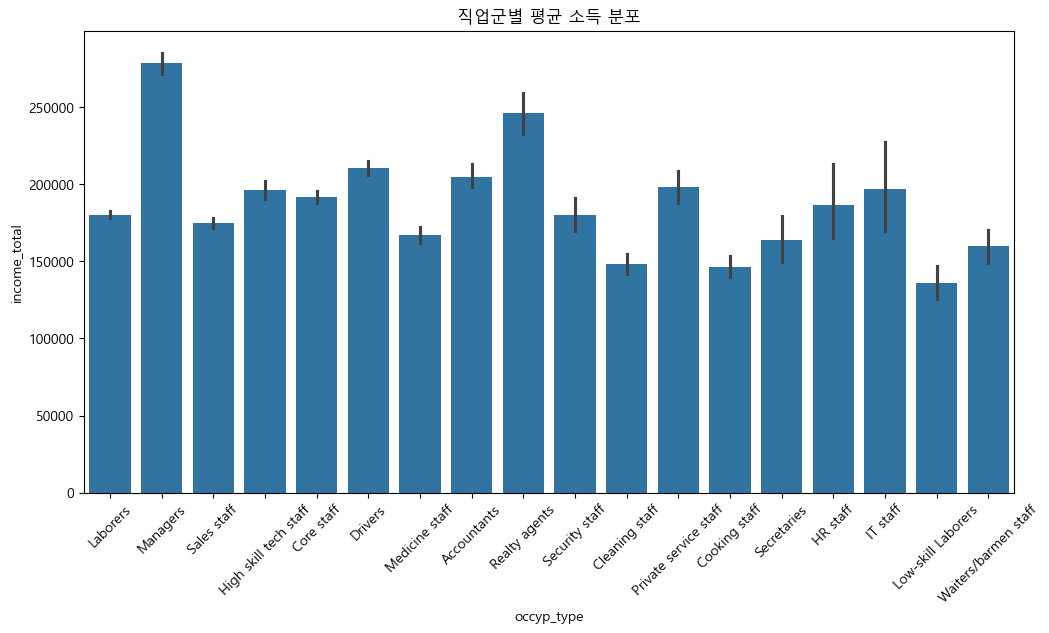

In [2]:
# 직업군별 평균 소득 시각화 (피처 엔지니어링의 근거)
plt.figure(figsize=(12, 6))
sns.barplot(x='occyp_type', y='income_total', data=train)
plt.xticks(rotation=45)
plt.title('직업군별 평균 소득 분포')
plt.show()

## 3. 데이터 전처리 (Preprocessing)

In [3]:
def basic_prep(df):
    # 이상치 및 날짜 처리
    if 'DAYS_EMPLOYED' in df.columns:
        df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
        df['DAYS_EMPLOYED'] = np.abs(df['DAYS_EMPLOYED'])
    if 'DAYS_BIRTH' in df.columns:
        df['DAYS_BIRTH'] = np.abs(df['DAYS_BIRTH'])
    if 'begin_month' in df.columns:
        df['begin_month'] = np.abs(df['begin_month'])
    if 'occyp_type' in df.columns:
        df['occyp_type'] = df['occyp_type'].fillna('None')
    
    # 단순 불필요 컬럼 제거
    if 'FLAG_MOBIL' in df.columns:
        df.drop('FLAG_MOBIL', axis=1, inplace=True)
    return df

train = basic_prep(train)
test = basic_prep(test)


## 4. 피처 엔지니어링 (Feature Engineering)
**[Private 4위 전략 제안 적용]**: 그룹별 집계 통계량 및 비율 피처를 대폭 추가합니다.

In [4]:
def advanced_fe(df):
    # 1. 고용 비율 및 나이 관련 기본 피처
    if 'DAYS_EMPLOYED' in df.columns and 'DAYS_BIRTH' in df.columns:
        df['employed_ratio'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    if 'income_total' in df.columns and 'family_size' in df.columns:
        df['income_per_person'] = df['income_total'] / df['family_size']
    
    # 2. 그룹별 통계 피처
    group_cols = ['occyp_type', 'edu_type', 'income_type']
    for col in group_cols:
        if col in df.columns:
            df[f'{col}_income_mean'] = df.groupby(col)['income_total'].transform('mean')
            df[f'{col}_income_ratio'] = df['income_total'] / df[f'{col}_income_mean']
        
    # 3. 빈도 인코딩
    for col in ['occyp_type', 'house_type']:
        if col in df.columns:
            enc_ref = df[col].value_counts() / len(df)
            df[f'{col}_freq'] = df[col].map(enc_ref)
    
    return df

train = advanced_fe(train)
test = advanced_fe(test)


## 5. 모델링 준비 (Encoding & Scaling)

In [7]:
from sklearn.preprocessing import LabelEncoder

cat_cols = train.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    le.fit(pd.concat([train[col], test[col]], axis=0))  # train+test 합쳐서 fit
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])

In [6]:
from sklearn.preprocessing import LabelEncoder

cat_cols = train.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    le.fit(train[col])  # train 기준으로만 fit
    train[col] = le.transform(train[col])
    test[col] = test[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

## 6. 모델링 (Catboost) - 10 Fold Cross Validation
일반화 성능을 극대화하기 위해 10-Fold 학습을 진행합니다.

In [8]:
print(test.columns)


Index(['gender', 'car', 'reality', 'income_total', 'income_type', 'edu_type',
       'family_type', 'house_type', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'before_EMPLOYED',
       'income_total_befofeEMP_ratio', 'Age', 'EMPLOYED', 'DAYS_BIRTH_m',
       'DAYS_BIRTH_w', 'DAYS_EMPLOYED_m', 'DAYS_EMPLOYED_w', 'ability',
       'income_mean', 'income_age', 'income_emp', 'ID', 'cluster',
       'income_per_person', 'occyp_type_income_mean',
       'occyp_type_income_ratio', 'edu_type_income_mean',
       'edu_type_income_ratio', 'income_type_income_mean',
       'income_type_income_ratio', 'occyp_type_freq', 'house_type_freq'],
      dtype='object')


In [9]:
X = train.drop(['gender', 'car'], axis=1)
y = train['car']
X_test = test.drop(['gender'], axis=1)


In [10]:
import numpy as np

cat_probs = np.zeros((len(X_test), 3))  # 클래스 개수에 맞게 수정


In [11]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#  cat_probs = np.zeros((len(X_test), 3))

for fold , (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"--- Fold {fold+1} Training Starting ---")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = CatBoostClassifier(
        iterations=2500,
        learning_rate=0.02,
        depth=8,
        random_seed=42,
        early_stopping_rounds=200,
        verbose=200
    )
    
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], use_best_model=True)
    # cat_probs = model.predict_proba(X_test) / 10

submission.iloc[:, 1:] = cat_probs
submission.to_csv('top_performance_submission.csv', index=False)
print("최종 제출 파일이 생성되었습니다!")


--- Fold 1 Training Starting ---
0:	learn: 0.6885858	test: 0.6886100	best: 0.6886100 (0)	total: 156ms	remaining: 6m 28s
200:	learn: 0.4990862	test: 0.5174201	best: 0.5174201 (200)	total: 1.87s	remaining: 21.4s
400:	learn: 0.4429819	test: 0.4741553	best: 0.4741553 (400)	total: 3.64s	remaining: 19s
600:	learn: 0.3981266	test: 0.4398889	best: 0.4398889 (600)	total: 5.39s	remaining: 17s
800:	learn: 0.3597343	test: 0.4103585	best: 0.4103585 (800)	total: 7.19s	remaining: 15.2s
1000:	learn: 0.3277479	test: 0.3853919	best: 0.3853919 (1000)	total: 8.92s	remaining: 13.4s
1200:	learn: 0.3021086	test: 0.3664903	best: 0.3664903 (1200)	total: 10.7s	remaining: 11.5s
1400:	learn: 0.2798206	test: 0.3493001	best: 0.3493001 (1400)	total: 12.4s	remaining: 9.71s
1600:	learn: 0.2596575	test: 0.3335002	best: 0.3335002 (1600)	total: 14.1s	remaining: 7.93s
1800:	learn: 0.2417118	test: 0.3203172	best: 0.3203172 (1800)	total: 15.9s	remaining: 6.15s
2000:	learn: 0.2262501	test: 0.3087133	best: 0.3087133 (2000)	to